In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn-colorblind')
import scipy.stats as sps
import networkx as nx
import time
from Dist_KL_UCB import Dist_KL_UCB
from Dist_UCB1 import Dist_UCB1
import os
from multiprocess import Pool

n_runs = 100
T = 10000
N = 20
rwd_means = [.2, .3, .4, .5, .6]

seeds = []
myseed = 0
while len(seeds) < n_runs:
    G = nx.fast_gnp_random_graph(N, 0.5, directed=False, seed=myseed)
    if nx.is_connected(G):
        seeds.append(myseed)
    myseed += 1

sd = 0.1
distributions = [[sps.truncnorm(a=(0-rwd_means[i])/sd, b=(1-rwd_means[i])/sd, loc=rwd_means[i], scale=sd) for i in range(len(rwd_means))] for n in range(N)]
for n in range(N):
    for i in range(len(rwd_means)):
        distributions[n][i].random_state = np.random.RandomState(seed=1)
sigmas = [1, .1, .01]

In [2]:
def worker(job_runs, seeds, sigmas, T, N, distributions):
    mean_regrets_dist_kl_ucb = np.zeros((len(job_runs), len(sigmas), T))
    mean_regrets_dist_ucb1 = np.zeros((len(job_runs), len(sigmas), T))
    for run in job_runs:
        start_run_t = time.time()
        G = nx.fast_gnp_random_graph(N, 0.5, directed=False, seed=seeds[run])
        nodes = list(G.nodes)
        for i in nodes:
            G.add_edge(i,i) 
        for sig in range(len(sigmas)):
            distkl = Dist_KL_UCB(T, distributions, G, sigma=sigmas[sig])
            distkl.run()
            mean_regrets_dist_kl_ucb[run - job_runs[0], sig, :] = np.mean(distkl.regrets, axis=0)
            distucb1 = Dist_UCB1(T, distributions, G, beta=sigmas[sig])
            distucb1.run()
            mean_regrets_dist_ucb1[run - job_runs[0], sig, :] = np.mean(distucb1.regrets, axis=0)
        end_run_t = time.time()
        print(f'finished run {run} in {end_run_t - start_run_t}sec')
    return mean_regrets_dist_kl_ucb, mean_regrets_dist_ucb1


In [3]:
mean_regrets_dist_kl_ucb = np.zeros((n_runs, len(sigmas), T))
mean_regrets_dist_ucb1 = np.zeros((n_runs, len(sigmas), T))
cpus = os.cpu_count()
init_time = time.time()

pool = Pool() # no need to pass in cpus, does os.cpu_count() by default
jobs = list(range(n_runs))
job_size = max(n_runs // cpus, 1)
job_chunks = [(jobs[i:i + job_size], seeds, sigmas, T, N, distributions) for i in range(0, len(jobs), job_size)]
results = pool.starmap(worker, job_chunks)
pool.close()
pool.join()
mean_regrets_dist_kl_ucb_unconcat = [result[0] for result in results]
mean_regrets_dist_ucb1_unconcat = [result[1] for result in results]
np.concatenate(mean_regrets_dist_kl_ucb_unconcat, out=mean_regrets_dist_kl_ucb)
np.concatenate(mean_regrets_dist_ucb1_unconcat, out=mean_regrets_dist_ucb1)

end_run_t = time.time()

time_axis = list(range(T))
mean_regrets_over_all_runs_dist_kl_ucb = np.mean(mean_regrets_dist_kl_ucb, axis=0)
std_regrets_over_all_runs_dist_kl_ucb = np.std(mean_regrets_dist_kl_ucb, axis=0)
mean_regrets_over_all_runs_dist_ucb1 = np.mean(mean_regrets_dist_ucb1, axis=0)
std_regrets_over_all_runs_dist_ucb1 = np.std(mean_regrets_dist_ucb1, axis=0)
print(f'Total run time = {end_run_t - init_time}sec')

finished run 84 in 255.70151805877686sec
finished run 24 in 264.6368203163147sec
finished run 0 in 264.8898718357086sec
finished run 72 in 272.25917315483093sec
finished run 12 in 278.2631461620331sec
finished run 36 in 282.6220271587372sec
finished run 48 in 316.08256816864014sec
finished run 60 in 334.8811299800873sec
finished run 1 in 294.2438130378723sec
finished run 85 in 320.80601978302sec
finished run 73 in 307.43243312835693sec
finished run 37 in 299.4625051021576sec
finished run 13 in 318.0321989059448sec
finished run 25 in 349.27816009521484sec
finished run 49 in 321.408194065094sec
finished run 61 in 325.82543206214905sec
finished run 86 in 311.19133019447327sec
finished run 2 in 329.5198130607605sec
finished run 14 in 346.2604820728302sec
finished run 38 in 360.5066590309143sec
finished run 26 in 335.1614751815796sec
finished run 74 in 374.18719005584717sec
finished run 50 in 335.40746426582336sec
finished run 62 in 367.43687295913696sec
finished run 3 in 342.48331594467163

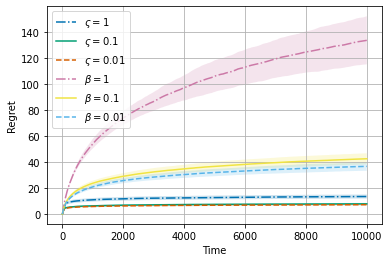

In [4]:
linestyles = ['-.', '-', '--']
for sig in range(len(sigmas)):
    plt.plot(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[sig], linestyles[sig], label=r"$\varsigma=$" + str(sigmas[sig]))
    plt.fill_between(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[sig]-std_regrets_over_all_runs_dist_kl_ucb[sig], mean_regrets_over_all_runs_dist_kl_ucb[sig]+std_regrets_over_all_runs_dist_kl_ucb[sig],alpha=.2)
for sig in range(len(sigmas)):    
    plt.plot(time_axis, mean_regrets_over_all_runs_dist_ucb1[sig], linestyles[sig], label=r"$\beta=$" + str(sigmas[sig]))
    plt.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb1[sig]-std_regrets_over_all_runs_dist_ucb1[sig], mean_regrets_over_all_runs_dist_ucb1[sig]+std_regrets_over_all_runs_dist_ucb1[sig],alpha=.2)
plt.xlabel("Time")
plt.ylabel("Regret")
plt.legend()
plt.grid()
plt.savefig("dist_KL_vs_dist_UCB1.pdf", bbox_inches='tight')

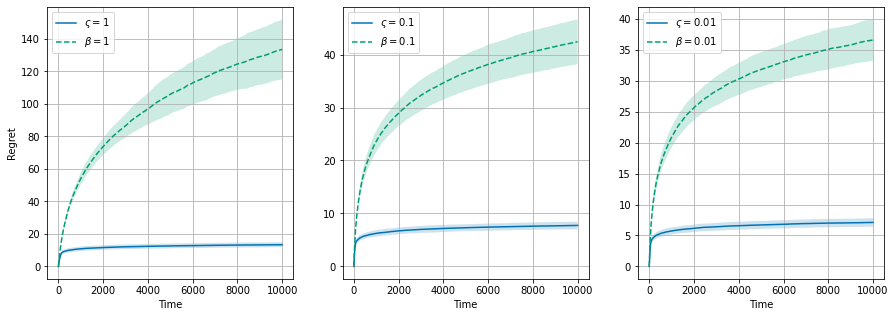

In [5]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
linestyles = ['-', '--']
ax1.plot(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[0], linestyles[0], label=r"$\varsigma=$" + str(sigmas[0]))
ax1.fill_between(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[0]-std_regrets_over_all_runs_dist_kl_ucb[0], mean_regrets_over_all_runs_dist_kl_ucb[0]+std_regrets_over_all_runs_dist_kl_ucb[0],alpha=.2)
ax1.plot(time_axis, mean_regrets_over_all_runs_dist_ucb1[0], linestyles[1], label=r"$\beta=$" + str(sigmas[0]))
ax1.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb1[0]-std_regrets_over_all_runs_dist_ucb1[0], mean_regrets_over_all_runs_dist_ucb1[0]+std_regrets_over_all_runs_dist_ucb1[0],alpha=.2)
ax1.legend()
ax1.grid()
ax1.set_xlabel("Time")
ax1.set_ylabel("Regret")

ax2.plot(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[1], linestyles[0], label=r"$\varsigma=$" + str(sigmas[1]))
ax2.fill_between(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[1]-std_regrets_over_all_runs_dist_kl_ucb[1], mean_regrets_over_all_runs_dist_kl_ucb[1]+std_regrets_over_all_runs_dist_kl_ucb[1],alpha=.2)
ax2.plot(time_axis, mean_regrets_over_all_runs_dist_ucb1[1], linestyles[1], label=r"$\beta=$" + str(sigmas[1]))
ax2.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb1[1]-std_regrets_over_all_runs_dist_ucb1[1], mean_regrets_over_all_runs_dist_ucb1[1]+std_regrets_over_all_runs_dist_ucb1[1],alpha=.2)
ax2.legend()
ax2.grid()
ax2.set_xlabel("Time")

ax3.plot(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[2], linestyles[0], label=r"$\varsigma=$" + str(sigmas[2]))
ax3.fill_between(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[2]-std_regrets_over_all_runs_dist_kl_ucb[2], mean_regrets_over_all_runs_dist_kl_ucb[2]+std_regrets_over_all_runs_dist_kl_ucb[2],alpha=.2)
ax3.plot(time_axis, mean_regrets_over_all_runs_dist_ucb1[2], linestyles[1], label=r"$\beta=$" + str(sigmas[2]))
ax3.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb1[2]-std_regrets_over_all_runs_dist_ucb1[2], mean_regrets_over_all_runs_dist_ucb1[2]+std_regrets_over_all_runs_dist_ucb1[2],alpha=.2)
ax3.legend()
ax3.grid()
ax3.set_xlabel("Time")

plt.savefig("dist_KL_vs_dist_UCB1_3subplots.pdf", bbox_inches='tight')